In [9]:
import os
import sys
sys.path.insert(0, '..')

import argparse
import random
import numpy as np
import pandas as pd
import pickle
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from pathlib import Path
from utils import *
from model.metric import evaluate, predicate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from model.utils import remove_punct, sent_tokenize, stemming, lemmatize, preprocess_text
from torch.utils.tensorboard import SummaryWriter

In [10]:
home_dir = Path('..')
data_dir = home_dir / 'dataset' / 'SDAC'
save_dir = home_dir / 'experiment' / 'SDAC'
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
# pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'

# if not (home_dir / save_dir / data_name).exists():
#     (home_dir / save_dir / data_name)
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [11]:
args = {
    "epochs": 30,
    "n_batch": 64,
    "max_len": 256,
    "lr": 1e-5,
    "summary_step": 10000,
    "embedding_dim": 128,
    "hidden_size": 256,
    "n_layers": 1,
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=128, epochs=30, hidden_size=256, lr=1e-05, max_len=256, n_batch=64, n_layers=1, summary_step=10000)


In [12]:
# with open(data_dir / pretrained_embeddings_name, 'rb') as f:
#     pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

## Train

In [13]:
train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])


x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming]

x_train = x_train.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)
x_valid = x_valid.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

In [15]:
x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))

y_train = list(convert_label_to_idx(y_train, label2idx))
y_valid = list(convert_label_to_idx(y_valid, label2idx))

In [16]:
tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

In [17]:
learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       dropout=dropout, bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

loss_fn = LSR(epsilon=0.1, num_classes=output_size)

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

writer = SummaryWriter(f'{save_dir}/runs')
checkpoint_manager = CheckpointManager(save_dir)
summary_manager = SummaryManager(save_dir)

In [18]:
best_val_loss = 1e+10
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []
x_error_check = []

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='steps', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
        x_error_check.append(x_mb)
        if len(x_error_check) > 2:
            del x_error_check[0]
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        valid_acc.append(val_sum['acc'])
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            summary_manager.update(summary)
            summary_manager.save('summary.json')
            checkpoint_manager.save_checkpoint(state, 'best.tar')
            best_val_loss = val_loss

steps: 100%|██████████| 51/51 [00:00<00:00, 250.25it/s]


global_Step:   0, tr_loss: 1.244395, val_loss: 1.242528


steps:  43%|████▎     | 22/51 [00:00<00:00, 218.50it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 251.44it/s]


epoch : 1, tr_loss:  0.850641, val_loss: 0.620, tr_acc: 48.68%, val_acc: 57.33%


steps:  43%|████▎     | 22/51 [00:00<00:00, 216.29it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 232.27it/s]


epoch : 2, tr_loss:  0.641508, val_loss: 0.560, tr_acc: 59.06%, val_acc: 61.28%


steps:  41%|████      | 21/51 [00:00<00:00, 206.90it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 219.82it/s]


epoch : 3, tr_loss:  0.600596, val_loss: 0.534, tr_acc: 61.93%, val_acc: 65.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 249.29it/s]


global_Step: 10000, tr_loss: 0.587072, val_loss: 0.530631


steps:  45%|████▌     | 23/51 [00:00<00:00, 226.76it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 233.39it/s]


epoch : 4, tr_loss:  0.578586, val_loss: 0.521, tr_acc: 63.57%, val_acc: 65.77%


steps:  45%|████▌     | 23/51 [00:00<00:00, 225.72it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 237.10it/s]


epoch : 5, tr_loss:  0.565061, val_loss: 0.508, tr_acc: 64.57%, val_acc: 66.47%


steps:  43%|████▎     | 22/51 [00:00<00:00, 216.10it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 225.12it/s]


epoch : 6, tr_loss:  0.553061, val_loss: 0.498, tr_acc: 65.31%, val_acc: 67.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 303.65it/s]


global_Step: 20000, tr_loss: 0.544389, val_loss: 0.489749


steps: 100%|██████████| 51/51 [00:00<00:00, 290.30it/s]


epoch : 7, tr_loss:  0.543288, val_loss: 0.491, tr_acc: 66.06%, val_acc: 68.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 294.92it/s]


epoch : 8, tr_loss:  0.534723, val_loss: 0.485, tr_acc: 66.73%, val_acc: 69.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.39it/s]


epoch : 9, tr_loss:  0.526918, val_loss: 0.475, tr_acc: 67.24%, val_acc: 69.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.11it/s]


global_Step: 30000, tr_loss: 0.520998, val_loss: 0.472202


steps:  45%|████▌     | 23/51 [00:00<00:00, 225.03it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 230.93it/s]


epoch : 10, tr_loss:  0.520949, val_loss: 0.469, tr_acc: 67.67%, val_acc: 69.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 258.94it/s]


epoch : 11, tr_loss:  0.514981, val_loss: 0.470, tr_acc: 68.16%, val_acc: 69.56%


steps:  43%|████▎     | 22/51 [00:00<00:00, 217.86it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 227.98it/s]


epoch : 12, tr_loss:  0.510418, val_loss: 0.463, tr_acc: 68.43%, val_acc: 70.42%


steps:  49%|████▉     | 25/51 [00:00<00:00, 247.39it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 241.61it/s]


epoch : 13, tr_loss:  0.505872, val_loss: 0.460, tr_acc: 68.68%, val_acc: 70.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 253.36it/s]


global_Step: 40000, tr_loss: 0.505245, val_loss: 0.453251


steps:  47%|████▋     | 24/51 [00:00<00:00, 231.70it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 235.29it/s]


epoch : 14, tr_loss:  0.502540, val_loss: 0.455, tr_acc: 69.03%, val_acc: 70.81%


steps:  43%|████▎     | 22/51 [00:00<00:00, 218.71it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 218.40it/s]


epoch : 15, tr_loss:  0.498127, val_loss: 0.453, tr_acc: 69.23%, val_acc: 71.15%


steps:  49%|████▉     | 25/51 [00:00<00:00, 245.57it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 237.73it/s]


epoch : 16, tr_loss:  0.495719, val_loss: 0.449, tr_acc: 69.42%, val_acc: 71.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 253.20it/s]


global_Step: 50000, tr_loss: 0.492422, val_loss: 0.445168


steps:  51%|█████     | 26/51 [00:00<00:00, 254.18it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 247.58it/s]


epoch : 17, tr_loss:  0.492390, val_loss: 0.445, tr_acc: 69.65%, val_acc: 71.91%


steps:  45%|████▌     | 23/51 [00:00<00:00, 224.14it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 229.19it/s]

epoch : 18, tr_loss:  0.490011, val_loss: 0.445, tr_acc: 69.88%, val_acc: 71.45%


steps: 100%|██████████| 51/51 [00:00<00:00, 304.32it/s]


epoch : 19, tr_loss:  0.487461, val_loss: 0.440, tr_acc: 69.95%, val_acc: 72.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 254.19it/s]


global_Step: 60000, tr_loss: 0.484503, val_loss: 0.436527


steps:  47%|████▋     | 24/51 [00:00<00:00, 232.78it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 235.53it/s]


epoch : 20, tr_loss:  0.484706, val_loss: 0.439, tr_acc: 70.11%, val_acc: 72.43%


steps:  49%|████▉     | 25/51 [00:00<00:00, 239.24it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 230.00it/s]


epoch : 21, tr_loss:  0.482519, val_loss: 0.437, tr_acc: 70.27%, val_acc: 72.22%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.97it/s]


epoch : 22, tr_loss:  0.480171, val_loss: 0.432, tr_acc: 70.34%, val_acc: 72.62%


steps:  49%|████▉     | 25/51 [00:00<00:00, 238.12it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 241.01it/s]

epoch : 23, tr_loss:  0.478835, val_loss: 0.437, tr_acc: 70.39%, val_acc: 72.49%


steps: 100%|██████████| 51/51 [00:00<00:00, 254.16it/s]


global_Step: 70000, tr_loss: 0.479421, val_loss: 0.437424


steps:  49%|████▉     | 25/51 [00:00<00:00, 243.12it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 254.02it/s]

epoch : 24, tr_loss:  0.476417, val_loss: 0.434, tr_acc: 70.60%, val_acc: 72.34%


steps:  43%|████▎     | 22/51 [00:00<00:00, 214.51it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 223.58it/s]


epoch : 25, tr_loss:  0.475062, val_loss: 0.430, tr_acc: 70.73%, val_acc: 72.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 255.48it/s]

epoch : 26, tr_loss:  0.473461, val_loss: 0.427, tr_acc: 70.87%, val_acc: 73.35%


steps: 100%|██████████| 51/51 [00:00<00:00, 260.11it/s]


global_Step: 80000, tr_loss: 0.470940, val_loss: 0.426941


steps:  47%|████▋     | 24/51 [00:00<00:00, 237.95it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 234.76it/s]

epoch : 27, tr_loss:  0.471510, val_loss: 0.427, tr_acc: 70.94%, val_acc: 73.07%


steps:  45%|████▌     | 23/51 [00:00<00:00, 222.05it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 226.52it/s]


epoch : 28, tr_loss:  0.469413, val_loss: 0.426, tr_acc: 71.08%, val_acc: 72.98%


steps:  49%|████▉     | 25/51 [00:00<00:00, 240.61it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 238.49it/s]


epoch : 29, tr_loss:  0.468582, val_loss: 0.426, tr_acc: 71.25%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.46it/s]


global_Step: 90000, tr_loss: 0.467388, val_loss: 0.423310


steps:  41%|████      | 21/51 [00:00<00:00, 208.65it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 223.04it/s]

epoch : 30, tr_loss:  0.466988, val_loss: 0.429, tr_acc: 71.36%, val_acc: 72.77%



    Issue) 갑자기 아래의 에러가 나는 경우
    
    (Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.FloatTensor instead 
     while checking arguments for embedding)
    
    tr_dl 에서 나오는 index가 갑자기 소수점으로 바뀌는 경우가 있음. 
    위 에러가 뜬 뒤, x_mb.dtype 을 해보면 데이터 타입이 torch.float32 로 바뀌어 있음.
    아마, batch 의 첫 번째 row가 empty일때, 이를 빼고 계산한뒤 다시 복구시킬때 gpu 에서 소수점으로 반환하는듯
    
    해결) 데이터 전처리시, punctuation 을 제거하지 않음. 문장중에 . 혹은 ? 만 있는 문장이 있기 때문에 empty sentence가 생김

In [19]:
summary

{'tr': {'loss': 0.4685822755435428, 'acc': 0.7124656936127745},
 'val': {'loss': 0.4264151770211665, 'acc': 0.7307457212713936}}

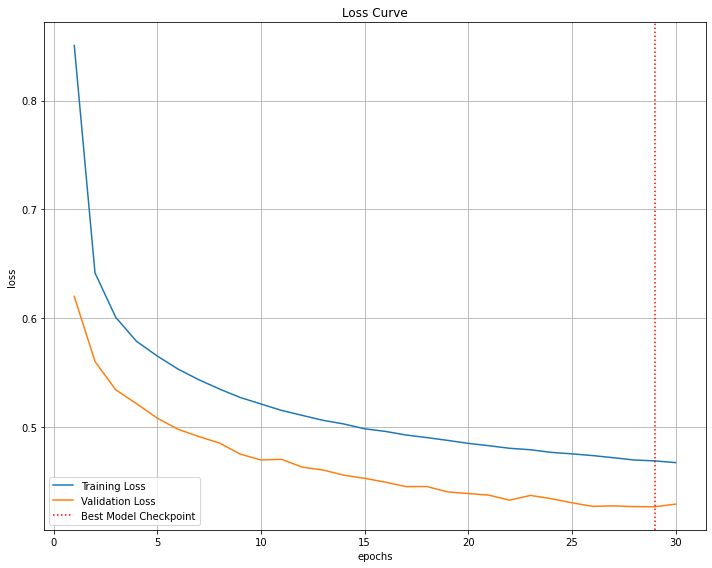

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='dotted', color='r',label='Best Model Checkpoint')

plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/loss_plot.png', bbox_inches = 'tight')

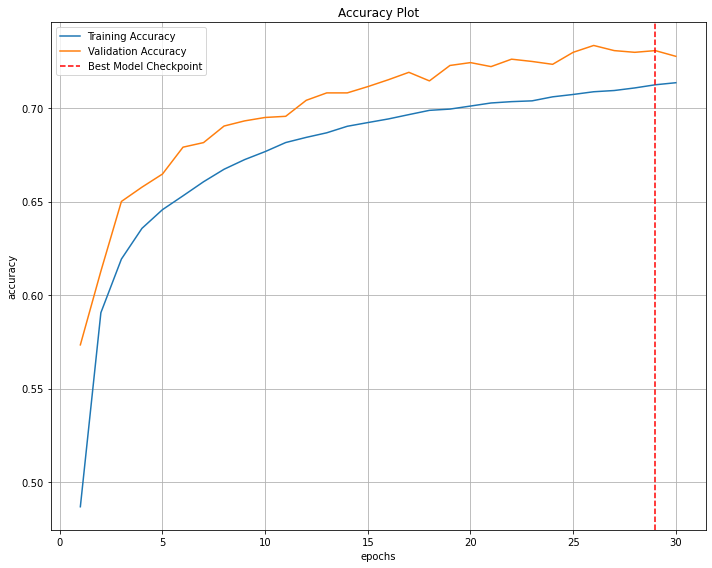

In [21]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1), train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1), valid_acc, label='Validation Accuracy')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Best Model Checkpoint')

plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/accuracy_plot.png', bbox_inches = 'tight')

## Evaluate

In [22]:
# with open(data_dir / pretrained_embeddings_name, 'rb') as f:
#     pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

learning_rate = args.lr
batch_size = 1
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

model.to(device)
loss_fn = LSR(epsilon=0.1, num_classes=output_size)

In [23]:
writer = SummaryWriter(f'{save_dir}/runs')
checkpoint_manager = CheckpointManager(save_dir)
summary_manager = SummaryManager(save_dir)

ckpt = checkpoint_manager.load_checkpoint('best.tar')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [23]:
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

x_test, y_test = test_data['utterance'], test_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming]
x_test = x_test.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

x_test = list(convert_token_to_idx(x_test, token2idx))
y_test = list(convert_label_to_idx(y_test, label2idx))

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=test_ds.collate_fn, drop_last=False)

In [24]:
summ = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager = SummaryManager(save_dir)
summary_manager.load('summary.json')
summary_manager.update(summ)
summary_manager.save('summary.json')

print('loss: {:3f}, acc: {:.2%}'.format(summ['loss'], summ['acc']))

steps: 100%|██████████| 4078/4078 [00:04<00:00, 845.92it/s]

loss: 1.250285, acc: 0.42%


### Make predictions

In [25]:
y_temp = [0]*len(x_test)
test_ds = DAdataset(x_test, y_temp)
test_dl = DataLoader(test_ds, batch_size=1) #, collate_fn=test_ds.collate_fn, shuffle=False, drop_last=False)
predicates = predicate(model, test_dl, device)

steps: 100%|██████████| 4078/4078 [00:03<00:00, 1179.29it/s]


In [26]:
y_pred = [idx2label[p] for p in predicates]
test_data['prediction'] = y_pred
test_data.head(50)

,speaker,utterance,tag,prediction
0,A,"Okay, uh,","fo_o_fw_""_by_bc",qw
1,A,could you tell me what you think contributes m...,qw,qrr
2,B,"Well, it's hard to say.",^h,qw^d
3,B,"I mean, while it's certainly the case that thi...",sv,qw^d
4,B,What do you think?,qo,qrr
5,A,"Um, well, you talked about, uh, volcanos.",sd,qw^d
6,A,I'm not sure how many active volcanos there ar...,sd,no
7,A,"I think probably the greatest cause is, uh, ve...",sv,no
8,B,Uh-huh.,b,ng
9,A,"Um, uh, do you live right in the city itself?",qy,qw^d


In [30]:
test_data['tag']

0       fo_o_fw_"_by_bc
1                    qw
2                    ^h
3                    sv
4                    qo
             ...       
4073                 fc
4074                 fc
4075                 fc
4076                 fc
4077                 fc
Name: tag, Length: 4078, dtype: object

In [33]:
y_pred

['qw',
 'qrr',
 'qw^d',
 'qw^d',
 'qrr',
 'qw^d',
 'no',
 'no',
 'ng',
 'qw^d',
 'qw^d',
 'ng',
 'ng',
 'ar',
 'ba',
 'bf',
 'qrr',
 'ng',
 'ng',
 'qw',
 'h',
 'ng',
 'qw^d',
 'aap_am',
 'ng',
 'aap_am',
 'ng',
 'aap_am',
 'qw^d',
 'aap_am',
 'bf',
 'ba',
 'aap_am',
 'qrr',
 'fc',
 'ng',
 'ng',
 'aap_am',
 'fc',
 'aap_am',
 'ng',
 '%',
 'ng',
 'ng',
 'ar',
 'aap_am',
 'arp_nd',
 'arp_nd',
 '^h',
 'ng',
 'bf',
 'arp_nd',
 'h',
 'aap_am',
 'ar',
 'qw^d',
 'ng',
 'qw^d',
 'ba',
 'ng',
 'ng',
 'ng',
 'no',
 'ng',
 'qw^d',
 'ng',
 'arp_nd',
 'h',
 'ng',
 'ng',
 'aap_am',
 'ng',
 'ng',
 'ng',
 'qrr',
 'qrr',
 'ng',
 'ng',
 'bf',
 'aap_am',
 'qw',
 'ng',
 'ng',
 'aap_am',
 'no',
 'ng',
 'ng',
 'ng',
 '^g',
 'no',
 'arp_nd',
 'ng',
 'ng',
 'ng',
 'ng',
 'qrr',
 'ng',
 'aap_am',
 'ng',
 'ng',
 'aap_am',
 'aap_am',
 'aap_am',
 'ng',
 'ng',
 'no',
 'aap_am',
 'ng',
 'ng',
 '^h',
 'qrr',
 'ng',
 'ng',
 'arp_nd',
 'qw^d',
 'ba',
 'arp_nd',
 'qrr',
 'ng',
 'qrr',
 'aap_am',
 'ng',
 'ba',
 'qw^d',
 '

In [34]:
test_data['tag']

0       fo_o_fw_"_by_bc
1                    qw
2                    ^h
3                    sv
4                    qo
             ...       
4073                 fc
4074                 fc
4075                 fc
4076                 fc
4077                 fc
Name: tag, Length: 4078, dtype: object

In [31]:
np.mean(np.array(test_data['tag']) == np.array(y_test))

0.0

https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
https://nbviewer.jupyter.org/github/simonjisu/pytorch_tutorials/blob/master/00_Basic_Utils/02_PackedSequence.ipynb

데이터 전처리: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221434157182

pretrained 사용: https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222